In [1]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

import matplotlib.pyplot as plt
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pickle

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Record Audio

In [2]:
def feature_extractor(sound_path, win_length_ms=25, hop_length_ms=10):
    # Load the audio file
    signal, sr = librosa.load(sound_path,sr=8000)
    # signal,sr = wavfile.read(sound_path)
    # Extract MFCCs
    win_length_samples = int(sr * win_length_ms / 1000)
    hop_length_samples = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length_samples, win_length=win_length_samples)
    # mfccs = mfcc(signal,samplerate=sr,nfft = 2048,numcep=13,nfilt=13)
    
    #Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [3]:
def preprocess(path, is_pca=0, num_pca = 2, window_length_ms=20, hop_length_ms=10):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=8000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    # samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file,window_length_ms,hop_length_ms)
    # tot= np.concatenate((a,b,c,d)).T
    tot = d.T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [4]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50,window_length_ms=20, hop_length_ms=10):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            # samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            # samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            # tot = np.concatenate((a, b, c, d)).T
            tot = d.T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

# Histogram plot to show that its mixture of gaussians

# Main Code

In [5]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans

In [6]:
train_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Train","../Dataset/Language-Recognition-VADaudio/Tamil-Train","../Dataset/Language-Recognition-VADaudio/Telugu-Train"]
test_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Test","../Dataset/Language-Recognition-VADaudio/Tamil-Test","../Dataset/Language-Recognition-VADaudio/Telugu-Test"]

In [7]:
import math
from scipy.stats import multivariate_normal
import numpy as np

def transform_to_diagonal_matrix(matrix):
    for i in range(len(matrix)):
        diag = np.einsum('ii->i', matrix[i])
        save = diag.copy()
        matrix[i][...] = 0
        matrix[i] = np.diag(save)
    return matrix


class GMM:
    def __init__(self,X,n_mixtures, covariance_type, max_iter = 40, tol = 0.0001):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.tol = tol
        self.X = X
        self.covariance_type = covariance_type
        
    def initialize(self):
        self.alpha = [(1/self.n_mixtures) for i in range(self.n_mixtures)]
        kmeans = KMeans(self.n_mixtures).fit(self.X)
        mu_k = kmeans.cluster_centers_
        self.mean  = mu_k
        sigma_ = [np.cov(np.array(self.X[kmeans.labels_==i].T)+0.1) for i in range(self.n_mixtures)]
        
        self.sigma = sigma_
        
    def expectation_step(self, X):
        self.likelihood_data = self.predict_likelihood(X)
        
    def maximization_step(self, X):
        self.alpha = np.mean(self.predict_likelihood(X), axis=0)
        
        for i in range(self.n_mixtures):
            like_prob = self.likelihood_data[:, i]
            num = X * like_prob.reshape((X.shape[0], 1))
            self.mean[i]  = np.sum(num, axis = 0) / np.sum(like_prob)
            
            cov = like_prob.reshape((1, X.shape[0])) * (X - self.mean[i]).T
            cov = cov.dot((X - self.mean[i]))
            cov /= np.sum(like_prob)
            self.sigma[i] = cov
            
            if self.covariance_type == 'diag':
                self.sigma = transform_to_diagonal_matrix(self.sigma)
    
    def predict_likelihood(self, X):
        likelihood = np.zeros( (X.shape[0], self.n_mixtures))
        
        for i in range(self.n_mixtures):
            distribution = multivariate_normal(mean=self.mean[i], cov=self.sigma[i],allow_singular=True)
            likelihood[:,i] = distribution.pdf(X)

            
        likelihood_gmm = likelihood * self.alpha
        total_likelihood = likelihood_gmm.sum(axis=1)[:, np.newaxis]
        likelihood_gmm = likelihood_gmm / total_likelihood
        return likelihood_gmm
    
    def calc_log_likelihood(self, X):
        likelihood = np.zeros( (X.shape[0], self.n_mixtures) )
        for i in range(self.n_mixtures):
            distribution = multivariate_normal(mean=self.mean[i], cov=self.sigma[i],allow_singular=True)
            likelihood[:,i] = distribution.pdf(X)

            
        numerator = likelihood * self.alpha
        #print("Num",numerator)
        log_like = np.log(np.sum(numerator, axis=1))
        log_like = np.sum(log_like)
        return log_like
    
    # X - n_samples, n_features
    def fit(self, X):
        
        self.initialize()
        log_likelihood = []
        last = self.max_iter
        
        for i in range(self.max_iter):
            self.expectation_step(X)
            self.maximization_step(X)
            
            log_likelihood.append(self.calc_log_likelihood(X))
            if i > 2 and abs(abs(log_likelihood[-1]) - abs(log_likelihood[-2])) < self.tol:
                last = i+1
                break
        
        plt.plot(range(last), log_likelihood,color='g', linewidth=2)
        plt.xlabel('Number of Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Variation of Log Likelihood for each iteration')
        plt.tight_layout()  
        plt.show()

In [8]:
class GMMNew:
    def __init__(
        self, 
        n_mixtures=120, 
        max_iter=100, 
        covar_type='full', 
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.log_likelihood_plot_list = None
        

    def p(self, data, mean, cov):
        dist = multivariate_normal(mean=mean, cov=cov,allow_singular=True)
        return dist.pdf(data)
    
    def predict(self, data):
        posteriors = np.zeros((len(data), self.n_mixtures))
        for i in range(self.n_mixtures):
            posteriors[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        labels = np.argmax(posteriors, axis=1)
        return labels
    
    def get_score(self,data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        return np.mean(np.log(resp.sum(axis=1)))
    
    def full_covar(self, data, resp):
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = data - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i].flat[::data.shape[1] + 1] += 1e-6
        return new_covs
            
    def diag_covar(self, data, resp):
        sqrd_data = np.dot(resp.T, data * data) / resp.sum(axis=0)[:, None]
        sqrd_means = self.means ** 2
        means = self.means * np.dot(resp.T, data) / resp.sum(axis=0)[:, None]
        diag_covs = (sqrd_data - 2 * means + sqrd_means + 1e-6)
        new_covs = [np.diag(cov) for cov in diag_covs]
        return new_covs
    
    def e_step(self, data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        # normalize the sum
        resp = resp / resp.sum(axis=1)[:, None]
        return resp
    
    def m_step(self, data, resp):        
        # re-estimation for alphas
        new_alphas = resp.mean(axis=0)
        
        # re-estimation for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i][:, None], data).sum(axis=0) / resp[:, i].sum()
        
        # re-estimation for covariance matrix
        if self.covar_type == 'full':
            new_covs = self.full_covar(data, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(data, resp)
        else:
            raise NotImplementedError()
            
        return new_alphas, new_means, new_covs
    
        
    def fit(self, data):
        n_features = data.shape[1]
        last = 0
        # intialize empty lists to store images and 
        self.log_likelihood_plot_list = []
        
        # initialize means
        kmeans_model =  KMeans(self.n_mixtures).fit(data)
        self.means = kmeans_model.cluster_centers_
        
        # initialize cov
        self.covs = np.zeros((self.n_mixtures, n_features, n_features))
        data_labels = kmeans_model.labels_

        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(data[data_labels == i].T+0.1)
        
        # EM - algorithm
        for step in range(self.max_iter):
            last = step
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(data)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(data, resp)
            
            
            # break if convergence
            if np.allclose(self.alphas, alphas, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.means, means, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.covs, covs, rtol=1e-4, atol=1e-4):
                print("Converged at",step)
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]

        # plt.plot(range(last), self.log_likelihood_plot_list,color='g', linewidth=2)
        # plt.xlabel('Number of Iteration')
        # plt.ylabel('Log Likelihood')
        # plt.title('Variation of Log Likelihood for each iteration')
        # plt.tight_layout()  
        # plt.show()
        

In [9]:
from sklearn.metrics import f1_score
def pipeline(n_components_gmm,is_pca,num_pca):
    gmms = []
    i = 0
    for path in train_paths:
        i += 1
        X = preprocess_folder(path,is_pca,num_pca,items=110)
        gmm = GMMNew(n_components_gmm,100,'full')
        gmm.fit(data=X)
        with open(f'gmm_{n_components_gmm}_{num_pca}_{i}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        gmms.append(gmm)
        print(f"{path} is done")

    # Initialize confusion matrix
    confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

    for idx, path in enumerate(test_paths):
        # Initialize counters for each class
        class_counts = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file,is_pca,num_pca)
                log_likelihood = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm    = gmms[i]  #checking with each model one by one
                    log_likelihood[i] = gmm.get_score(vector)
            
                winner = np.argmax(log_likelihood)
                class_counts[winner] += 1  # Increment the count for the winner class

        # Update confusion matrix
        for true_label, count in class_counts.items():
            confusion_matrix[idx, true_label] = count

    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")

## Plotting Graphs - Confusion Matrix

Num comp:32, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done


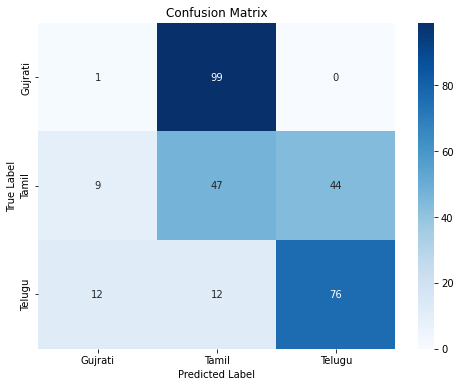

Overall Accuracy: 41.33%
Num comp:64, Num PCA:24
../Dataset/Language-Recognition-VADaudio/Gujrati-Train is done
../Dataset/Language-Recognition-VADaudio/Tamil-Train is done
../Dataset/Language-Recognition-VADaudio/Telugu-Train is done


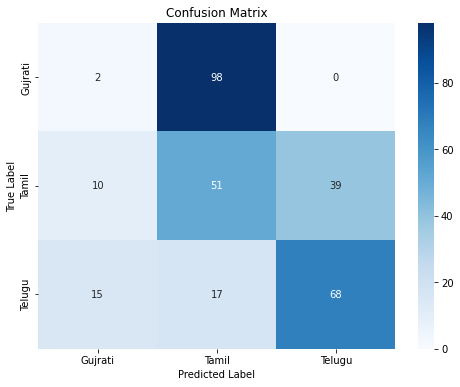

Overall Accuracy: 40.33%


In [10]:
import warnings
warnings.filterwarnings("ignore")

n_comp_list = [32,64]
num_pca_list = [24]
for num_pca_cand in num_pca_list:
    for n_comp in n_comp_list:
        print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
        if(num_pca_cand==39):
            is_pca = 0
        else:
            is_pca = 1
        pipeline(n_comp,is_pca,num_pca_cand)

# By using full dataset

In [11]:
def pipeline_full(n_components_gmm,is_pca,num_pca):
    gmms = []

    for path in train_paths:
        X = preprocess_folder(path,is_pca,num_pca,items=240)
        gmm = GMMNew(n_components_gmm,100,'full')
        gmm.fit(data=X)
        gmms.append(gmm)
        with open(f'gmmfull_{n_components_gmm}_{num_pca}.pkl', 'wb') as f:
            pickle.dump(gmm, f)
        print(f"{path} is done")

    # Initialize confusion matrix
    confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

    for idx, path in enumerate(test_paths):
        # Initialize counters for each class
        class_counts = {0: 0, 1: 0, 2: 0}
        for root, _, files in os.walk(path):
            for file in files:
                vector = preprocess(root+'/'+file,is_pca,num_pca)
                log_likelihood = np.zeros(len(gmms)) 
                for i in range(len(gmms)):
                    gmm    = gmms[i]  #checking with each model one by one
                    log_likelihood[i] = gmm.get_score(vector)
            
                winner = np.argmax(log_likelihood)
                class_counts[winner] += 1  # Increment the count for the winner class

        # Update confusion matrix
        for true_label, count in class_counts.items():
            confusion_matrix[idx, true_label] = count

    # Define class labels
    class_labels = ['Gujrati', 'Tamil', 'Telugu']

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")

In [12]:
# n_comp_list = [32,64,120,256,512]
# num_pca_list = [39,24,13,6]
# for num_pca_cand in num_pca_list:
#     for n_comp in n_comp_list:
#         print(f"Num comp:{n_comp}, Num PCA:{num_pca_cand}")
#         if(num_pca_cand==39):
#             is_pca = 0
#         else:
#             is_pca = 1
#         pipeline(n_comp,is_pca,num_pca_cand)